<a href="https://colab.research.google.com/github/mmichellesvv/color-blindless-detection/blob/main/ColorBlindlessApprox_unicolors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from skimage.color import rgb2lab, lab2rgb
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

**Project:** Unique colors for Colorblindness Detection  

**Abstract:**  
Project focuses on simulating color perception for different types of colorblindness (protanopia, deuteranopia, tritanopia, and monochromacy) and identifying unique color shades that minimize confusion. It includes:  

1. **Dataset** – Generating a base color set and simulating color vision deficiencies.  
2. **Processing**: Unique Colors Detection – Grouping colors using clustering algorithms and selecting distinct shades based on color variance metrics (RGB and LAB).  
3. **Results**: Confusion Samples – provide optimized palettes for colorblind users, improving accessibility and visual differentiation.

# **Dataset**: Genaration & Simulation

In [41]:
num_colors = 100

In [42]:
def colset(num_colors):
    """
    Generates a set of unique colors by clustering random RGB values using KMeans clustering.
    The number of clusters (unique colors) is specified by the num_colors parameter.
    After fitting the model, it scales the RGB values to a 0-255 range and returns the
    cluster centers as the resulting colors
    """
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    base_colors = np.random.rand(1000, 3)
    kmeans.fit(base_colors)
    unique_colors = (kmeans.cluster_centers_ * 255).astype(int)
    return unique_colors

In [43]:
healthy_rgb_colors = colset(num_colors)

In [44]:
def apply_colorblind_filter(rgb_colors, blindness_type):
    """
    Simulates colorblindness for different types of Daltonism.

    :param rgb_colors: An array of RGB colors (Nx3)
    :param blindness_type: Type of colorblindness ('protanopia', 'deuteranopia', 'tritanopia', 'monochromacy')
    :return: Modified colors for the respective type of colorblindness
    """
    modified_colors = rgb_colors.copy()

    if blindness_type == 'protanopia':
        modified_colors[:, 0] = modified_colors[:, 0] * 0.1  # Red channel impairment
        modified_colors[:, 1] = modified_colors[:, 1] * 1    # Green channel unaffected
        modified_colors[:, 2] = modified_colors[:, 2] * 0.8  # Blue channel impairment
    elif blindness_type == 'deuteranopia':
        modified_colors[:, 0] = modified_colors[:, 0] * 0.3  # Red channel impairment
        modified_colors[:, 1] = modified_colors[:, 1] * 0.7  # Green channel impairment
        modified_colors[:, 2] = modified_colors[:, 2] * 1    # Blue channel unaffected
    elif blindness_type == 'tritanopia':
        modified_colors[:, 1] = modified_colors[:, 1] * 0.5  # Green channel impairment
        modified_colors[:, 0] = modified_colors[:, 0] * 0.8  # Green channel impairment
        modified_colors[:, 1] = modified_colors[:, 2] * 0.9  # Green channel almost unaffected
    elif blindness_type == 'monochromacy':
        modified_colors[:, :] = np.mean(modified_colors, axis=1)[:, np.newaxis]  # All colors are perceived as shades of gray

    return modified_colors


In [45]:
def visualizing(colors, title, size=(15,10), label=' '):
    """
    Visualizes a given set of colors.

    :param colors: The colors to visualize (Nx3)
    :param title: Title of the plot
    :param size: Size of the figure (default is (15, 10))
    :param label: Additional label to add to the plot title
    """
    x, y = size
    plt.figure(figsize=(x, y))
    plt.imshow([colors])
    plt.title(f"{title.capitalize() + label}")
    plt.axis('off')
    plt.show()


In [46]:
blindness_types = ['protanopia', 'deuteranopia', 'tritanopia', 'monochromacy']

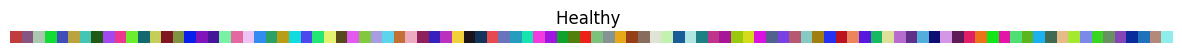

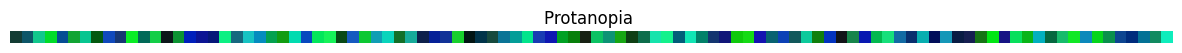

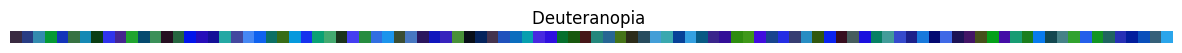

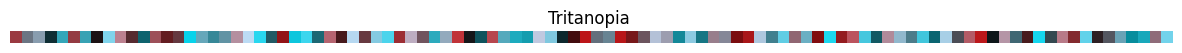

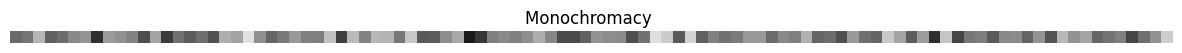

In [47]:
visualizing(healthy_rgb_colors, 'healthy')
for typ in blindness_types:
    modified_rgb_colors = apply_colorblind_filter(healthy_rgb_colors, typ)
    visualizing(modified_rgb_colors, typ)

# **Processing**: Unique Colors Detection

In [48]:
def process_clusters(colors, metric='euclidean', eps=3, min_samples=2):
    """
    Clusters colors using the DBSCAN algorithm.

    :param colors: Colors to be clustered (Nx3)
    :param metric: Distance metric used for clustering ('euclidean' by default)
    :param eps: The maximum distance between two points to be considered as in the same neighborhood
    :param min_samples: The number of samples in a neighborhood to form a core point
    :return: Cluster labels for each color
    """
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    labels = clustering.fit_predict(colors)
    return labels

In [49]:
def distance(healthy_rgb_colors, indices, blindness_type):
    """
    Calculates the variance of RGB values before and after applying the colorblind filter.

    :param healthy_rgb_colors: The original set of RGB colors
    :param indices: Indices of the colors to compare
    :param blindness_type: The type of color blindness to simulate
    :return: Variance of RGB values before and after filtering
    """
    original_colors = healthy_rgb_colors[indices]
    filtered_colors = apply_colorblind_filter(original_colors, blindness_type)
    return np.var(original_colors, axis=0).sum(), np.var(filtered_colors, axis=0).sum()


def filter_and_sort_distinct_colors(healthy_rgb_colors, indices, blindness_type, top_n=1):
    """
    Filters and sorts colors based on their dispersion in both RGB and LAB color spaces.

    :param healthy_rgb_colors: The original set of RGB colors
    :param indices: Indices of the colors to filter and sort
    :param blindness_type: The type of color blindness to simulate
    :param top_n: The number of top colors to return
    :return: Indices of the most distinct colors based on their dispersion
    """
    dispersion_data = []

    for i, idx in enumerate(indices):
        original_color = healthy_rgb_colors[idx]
        rgb_dispersion, lab_dispersion = distance(healthy_rgb_colors, [idx], blindness_type)

        for j, other_idx in enumerate(indices):
            if i != j:
                other_color = healthy_rgb_colors[other_idx]
                rgb_dispersion_other, lab_dispersion_other = distance(healthy_rgb_colors, [other_idx], blindness_type)
                dispersion_data.append((idx, other_idx, lab_dispersion, rgb_dispersion, lab_dispersion_other, rgb_dispersion_other))

    sorted_by_dispersion = sorted(dispersion_data, key=lambda x: (x[2] - x[4], abs(x[3] - x[5])))
    top_indices = [item[0] for item in sorted_by_dispersion[:top_n]] + [item[1] for item in sorted_by_dispersion[:top_n]]

    return list(set(top_indices))

In [50]:
all_clusters = {}
for typ in blindness_types:
    modified_rgb_colors = apply_colorblind_filter(healthy_rgb_colors, typ)
    modified_lab_colors = rgb2lab(modified_rgb_colors / 255.)

    labels = process_clusters(modified_lab_colors, metric='cityblock', eps=3, min_samples=2)

    cluster_groups = {}
    for label in np.unique(labels):
        if label == -1: continue
        indices = np.where(labels == label)[0]
        cluster_groups[label] = indices
    # print(cluster_groups)

    filtered_clusters = {}
    for label, indices in cluster_groups.items():
        filtered_indices = filter_and_sort_distinct_colors(healthy_rgb_colors, indices, typ)
        filtered_clusters[label] = filtered_indices
    all_clusters[typ] = filtered_clusters


Proccesing color clusters for each type of colorblindness. It applies the apply_colorblind_filter to simulate the effect of different blindness types and clusters the colors using the DBSCAN algorithm. Then, it visualizes both the original and filtered colors, and filters the most distinct colors based on dispersion using filter_and_sort_distinct_colors. The final results are stored in all_clusters.

In [51]:
pd.DataFrame(all_clusters)

,protanopia,deuteranopia,tritanopia,monochromacy
0,"[8, 25]","[97, 42]","[11, 79]","[0, 1]"
1,"[9, 60]",NaN,"[14, 30]","[79, 7]"
2,"[17, 61]",NaN,"[21, 15]","[20, 55]"
3,"[92, 21]",NaN,"[75, 19]",NaN
4,"[64, 46]",NaN,"[20, 29]",NaN
5,"[48, 69]",NaN,"[28, 87]",NaN
6,NaN,NaN,"[46, 31]",NaN
7,NaN,NaN,"[43, 36]",NaN
8,NaN,NaN,"[49, 52]",NaN
9,NaN,NaN,"[66, 92]",NaN


# **Results**: Confusion Samples

In [ ]:
size = (5,2)

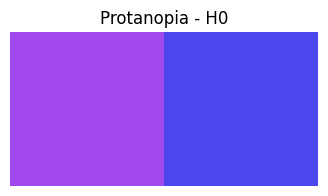

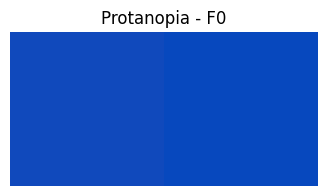

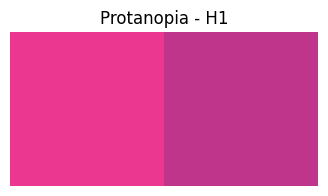

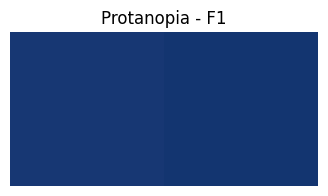

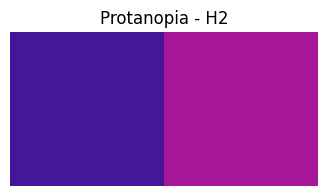

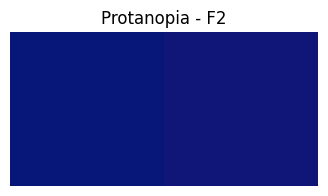

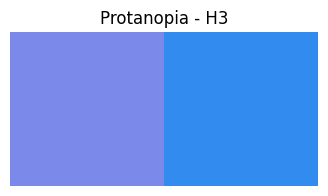

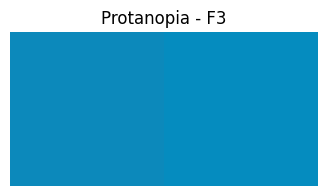

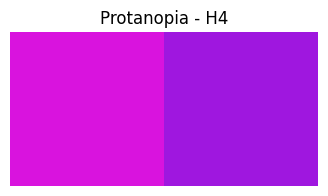

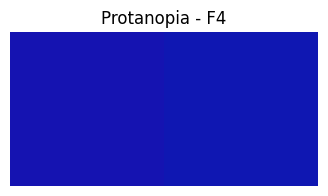

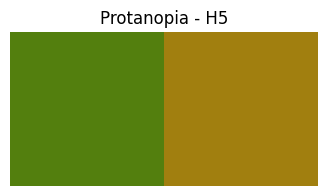

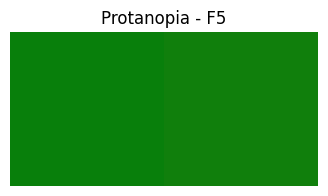

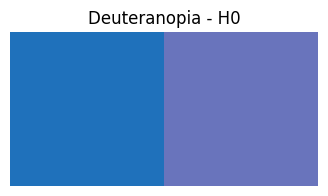

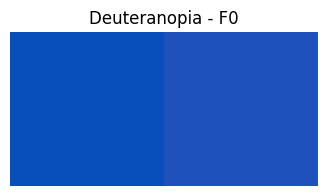

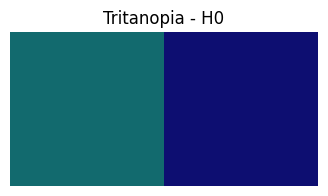

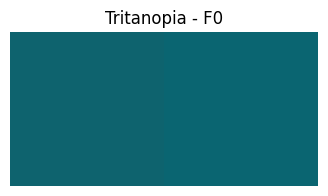

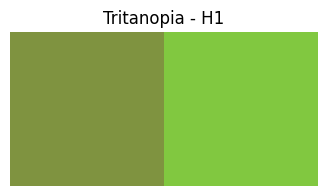

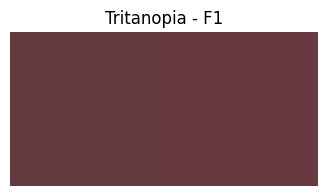

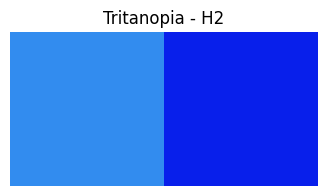

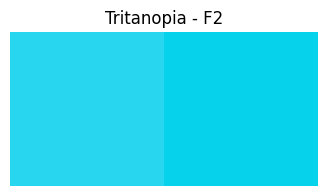

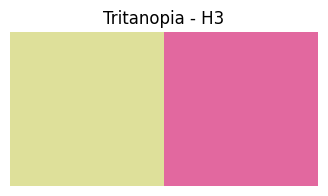

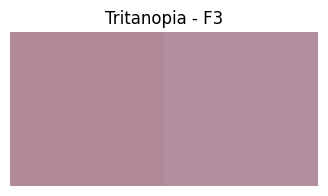

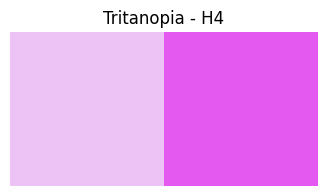

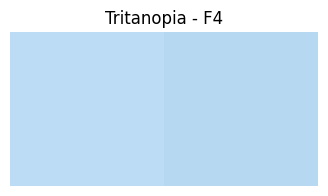

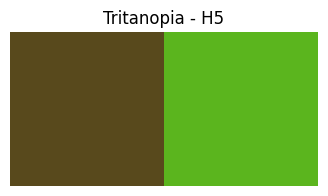

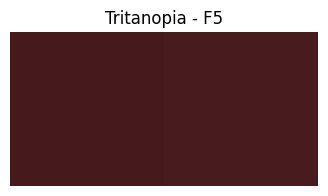

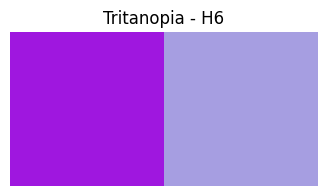

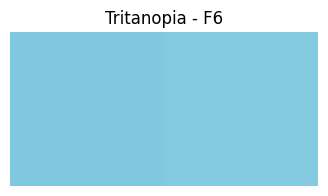

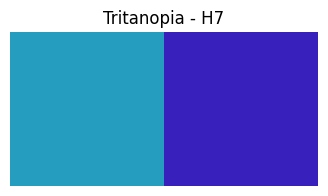

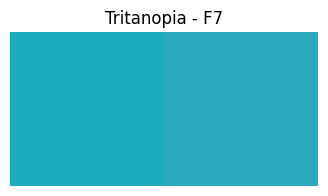

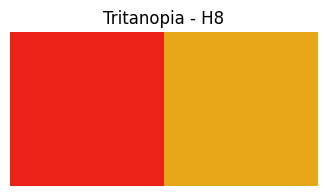

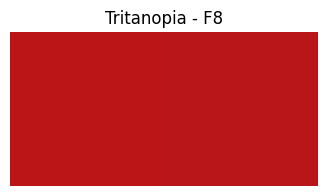

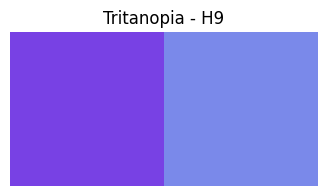

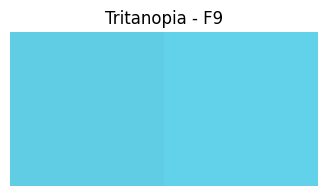

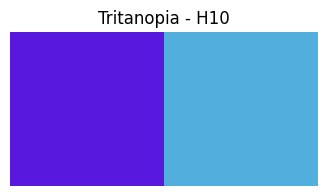

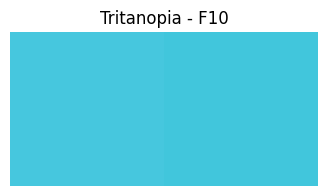

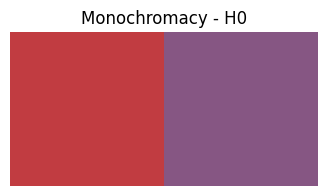

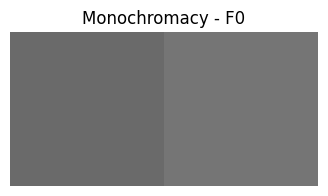

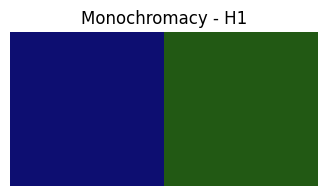

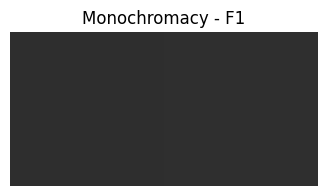

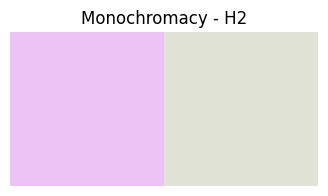

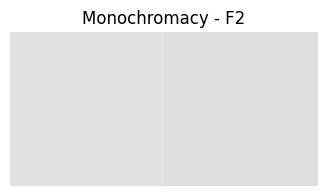

In [52]:
for typ, clusters in all_clusters.items():
    for label, indices in clusters.items():
        original_colors = healthy_rgb_colors[indices]
        filtered_colors = apply_colorblind_filter(healthy_rgb_colors[indices], typ)
        visualizing(original_colors, typ, size, label=f" - H{label}")
        visualizing(filtered_colors, typ, size, label=f" - F{label}")